**Project 1: Analyzing IMDB Movie Reviews for Their Sentiment, Making a Model**

The goal for this project is to take IMDB reviews, and perform a sentiment analysis of them. Then if possible, use the reviews to predict possible ratings given by the user who wrote the review. The data being used originally came from a user on the Kaggle website, which I usuing after trimming out unneccessary columns of data like time of the review, and generes to make the data less cumbersome for only looking at each movie's text review. As the project progresses, I can untrim movie ratings to try and utilize them with the project for validating predictions of movie ratings, if possible.
 
So far the main input being used is going to be each review in the review column in the .csv which has been trimmed up a little in the code.
 
With the goal of getting a sentiment analysis out of this, I am attempting to get the simplified text data to vectorize for further proccessing of the text. The exact output I plan to get will be two columns with each review's sentiment score as an integer and the second will say if it is positive or negative with a string or boolean. Which I may be able to use to further train a model for predicting possible ratings left by those reviewers.

**The Dataset**

IMBD Movie Rating (2022)
Original URL: https://www.kaggle.com/datasets/youssefamdouni/imbd-movie-rating

The dataset includes columns for: Title, Rating, Gender/Genre, Movie ID, and the review

35,485 entries by default, Trimmed .csv used has 20,000


**Training a Model to Calculate Sentiment**

Will be attempting to use the auto tokenizer tool, and then run a basic random forest to start art read results like in the tweet data project

In [25]:
# import all of the python modules/packages you'll need here
import pandas as pd
import re
import nltk
from textblob import TextBlob
#from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer

from argparse import Namespace
from collections import Counter
from nltk.corpus import stopwords
import json
import os
import re
import string

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
nltk.download('stopwords')
stop=set(stopwords.words('english'))
# ...



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Here is where I got started and was looking at the data I am working with. A couple graphs were used and tuned to get a goot cut off for the data compared to the full dataset.

   Unnamed: 0     Title  Global_Rating                    Gender   ID_Movie  \
0           0  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
1           1  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
2           2  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
3           3  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   
4           4  The Menu            7.2  Comedy  Horror  Thriller  tt9764362   

                                              Review  Unnamed: 6  Unnamed: 7  \
0  This is a movie that plays on something everyo...         NaN         NaN   
1  The hype for The Menu intrigued me. The review...         NaN         NaN   
2  This film was something else, I am genuinely s...         NaN         NaN   
3  Nice try, but the satire doesn't land in this ...         NaN         NaN   
4  "The Menu" offers a trailer spectacular enough...         NaN         NaN   

   Unnamed: 8  
0         NaN  
1         Na

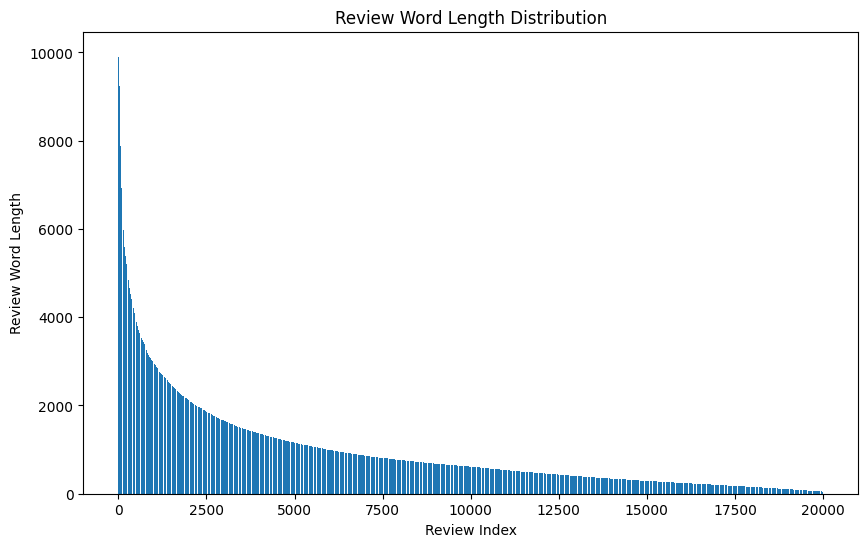

This graph shows that just of 10,000 reviews(half) are between 1,000 and 9,000 words long
This shows that 20% of the data contain reviews with between 1,000 and 14,000 characters in them


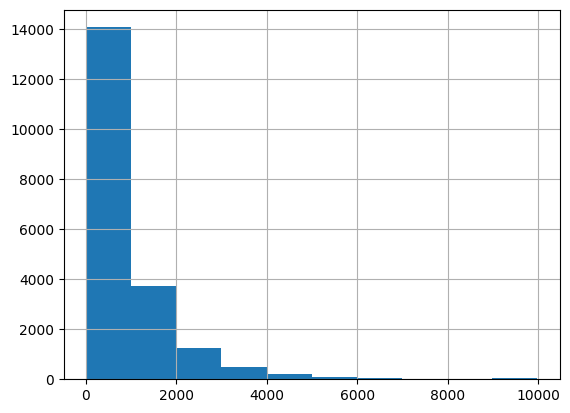

In [26]:
df = pd.read_csv('/kaggle/input/imdb-trimmed-reviews-20k-trimmed/IMDB_ratings3.csv')

print(df.head())
print (df.info())

#Make text_length hold the word count for each review
df['text_length'] = df['Review'].apply(len)
print(df['text_length'].describe())
print(df['Review'].head())

# Create a bar graph of review lengths
plt.figure(figsize=(10, 6))
sorted_df = df.sort_values(by='text_length', ascending=False)
plt.bar(range(len(sorted_df)), sorted_df['text_length'], align='center')
plt.xlabel('Review Index')
plt.ylabel('Review Word Length')
plt.title('Review Word Length Distribution')
plt.show()
print('This graph shows that just of 10,000 reviews(half) are between 1,000 and 9,000 words long')

#Data Exploration ideas from https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

df['Review'].str.len().hist()

print('This shows that 20% of the data contain reviews with between 1,000 and 14,000 characters in them')

# Define a function to calculate text length
def calculate_text_length(text):
    words = re.findall(r'\w+', text)
    return len(words)


The Vocabulary

In [27]:
class Vocabulary(object):
    #Proccesses the text, and tracks vocabulary for mapping
    
    def _init_(self, token_to_idx=None, add_unk=True,unk_token="<UNK>"):
        #token_to_idx (dict): a pre-existing map of tokens to indices
        #add_unk (bool): a flag that indicates whether to add the UNK token
        #unk_token (str): the UNK token to add into the Vocabulary
        
        
        if token_to_idx == None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token ={idx:token for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serialize(self):
        #Returns a serializable dictionary
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}
    @classmethod
    def fro_serializable(cls,content):
        return cls(**contents)
    
    def add_token(self,token):
        #update mapping dictionary based on token provided
        
        if token in self._token_t_idx:
            index = self._token_to_idx[token]
        else:
            index=len(self._token_to_idx[token])
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    def add_many(self, tokens):
        #adds list of tokens to vocab
        #inputs tokens(list) and returns index(list)/indices of tokens
        return[self.add_token(token)for token in tokens]
    
    def lookup_token(self,token):
        #Get the indexx associated with a token, or UNK_index if token not present
        if self.unk_index >= 0:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self.token_to_idx[token]
        
    def lookup_index(self, index):
        #Takes index and returns the token associated with it
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __str__(self):
        return"<Vocabulary(size=%d)>" % len(self)
    
    def __len__(self):
        return len(self._token_to_idx)






#...
#class Vocabulary(objective):
 #   def _init_(self, token_to_idx=None, add_unk+True, unk_token="<UNK>"):
 #       if token_to_idx is None:
 #           token_to_idx = {}
 #       self.token_to_idx = token_to_idx

The Vectorizor

In [28]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hit vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=20):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        stop_words = set(stopwords.words('english'))
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff and word not in stop_words:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        #create serializable dictionary for caching
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

The Dataset

In [29]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is at the correct device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

**Prep-work**

Here some of the text proccessing does function.

In [ ]:

def preprocess_text(text):
    #Set all text to lowercase
    text=text.lower()
    #Remove anything not a letter of the alphabet or a space, i.e, empty string replaces it
    text + re.sub(r'[^a-zA-Z\s]','', text)
    tokens = word_tokenize(text)
    #Remove stop words from tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return filtered_tokens
df['processed_text'] = df['Review'].apply(preprocess_text)

# Save the DataFrame with processed text back to a new CSV file
df.to_csv("preprocessed_sentiment_data.csv", index=False)
print(df['processed_text'].head())

# Get sentiment values from the tokenized reviews
#df['sentiment'] = df['processed_text'].apply(lambda review: TextBlob(review).sentiment)
df.sentiment.value_counts(normalize=True)
#df['processed_text'].dropna()
#df['sentiment'] = df['processed_text'].apply(lambda row: TextBlob(row['processed_text']).sentiment, axis=1)
#df['sentiment'] = df['processed_text'].sentiment

print(df['sentiment'].head())




args = Namespace(
    #Input data file(after pre-proccessing)
    input_data_path = '~/data/',
    review_csv = 'preprocessed_sentiment_data.csv',
    model_state_file = 'model.pth',
    #Output data and path info
    save_dir = '~/data/Project1/',
    vectorize_file = 'vectorizer.json',
    #Training parameters
    batch_size = 500,
    early_stopping_criteria = 3,
    learning_rate = 0.001,
    num_epochs = 6,
    seed = 42,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=False,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)
    

Initialization

In [ ]:
'''
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()
'''